# DeepAR


In [33]:
!python --version

Python 3.11.13


In [1]:
#!pip uninstall numpy
!pip install numpy==1.23.5
!pip install gluonts
!pip3 install mxnet-mkl

In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
path = '/content/gdrive/My Drive/data/time_series'
# https://www.kaggle.com/datasets/yasserh/walmart-dataset
data = pd.read_csv(path + '/walmart2.csv')
# convert string to datetime64
#data["ds"] = pd.to_datetime(data["Date"])
#data = data.sort_values(by=['Store','ds'])
data.tail()

,Unnamed: 0,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,ds
6430,6430,45,733037.32,0,78.65,3.722,191.162613,8.684,2012-10-08
6431,6431,45,718125.53,0,56.47,3.969,192.330854,8.667,2012-10-19
6432,6432,45,760281.43,0,58.85,3.882,192.308899,8.667,2012-10-26
6433,6433,45,770487.37,0,61.24,3.889,190.976417,8.567,2012-11-05
6434,6434,45,734464.36,0,54.47,4.000,192.327265,8.667,2012-12-10


Text(0.5, 1.0, 'Walmart Weekly Sales of Store 1 - 10')

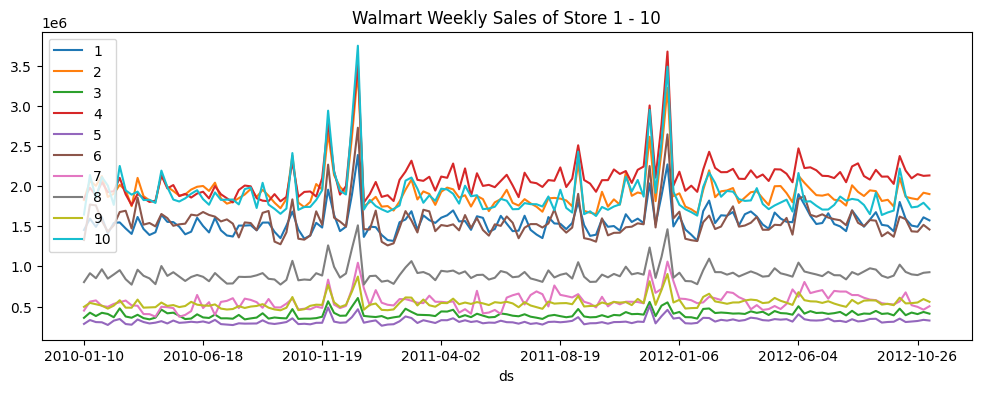

In [5]:
# pivot the data into the correct shape
storewide = data.pivot(index='ds', columns='Store', values='Weekly_Sales')
some_stores = storewide.loc[:,1:10] # Plot only Store 1 - 10
# plot the pivoted dataframe
some_stores.plot(figsize=(12, 4))
plt.legend(loc='upper left')
plt.title("Walmart Weekly Sales of Store 1 - 10")

In [6]:
print("The time series has", storewide.shape[0], "weeks")

The time series has 143 weeks


In [7]:
len_train = int(storewide.shape[0] * 0.85)
train_data = storewide[0:len_train]
test_data = storewide[len_train:]
[train_data.shape, test_data.shape]

[(121, 45), (22, 45)]

## GluonTS data preparation

In [8]:
# Prepare the data for deepAR format
from gluonts.dataset.common import ListDataset
from gluonts.dataset.field_names import FieldName

def to_deepar_format(dataframe, freq):
    start_index = dataframe.index.min()
    data = [{
                FieldName.START:  start_index,
                FieldName.TARGET:  dataframe[c].values,
            }
            for c in dataframe.columns]
    print(data[0])
    return ListDataset(data, freq=freq)
train_data_lds = to_deepar_format(train_data, 'W')
test_data_lds = to_deepar_format(test_data, 'W')

{'start': '2010-01-10', 'target': array([1453329.5 , 1594968.28, 1492418.14, 1611968.17, 1409727.59,
       1540163.53, 1548033.78, 1472515.79, 1404429.92, 1615524.71,
       1466058.28, 1391256.12, 1425100.71, 1643690.9 , 1554806.68,
       1551659.28, 1494251.5 , 1399662.07, 1432069.95, 1605491.78,
       1503284.06, 1422711.6 , 1603955.12, 1448938.92, 1385065.2 ,
       1371986.6 , 1508239.93, 1508237.76, 1513080.49, 1449142.92,
       1545418.53, 1546074.18, 1430378.67, 1351791.03, 1507460.69,
       1682614.26, 1459409.1 , 1345454.  , 1384209.22, 1542561.09,
       1483784.18, 1955624.11, 1641957.44, 1439541.59, 1494479.49,
       1891034.93, 2387950.2 , 1367320.01, 1495064.75, 1488538.09,
       1391013.96, 1327405.42, 1316899.31, 1550229.22, 1584083.95,
       1686842.78, 1456800.28, 1635078.41, 1576818.06, 1541102.38,
       1606629.58, 1636263.41, 1697229.58, 1559889.  , 1564819.81,
       1455090.69, 1624383.75, 1604775.58, 1428218.27, 1466046.67,
       1629391.28, 1532114.8

DeepAR Basic Hyperparameters:

- prediction_length: How many steps the model is going to predict
- context_length: The number of time-points that the model gets to see before making the prediction. The value for this parameter should be about the same as the prediction_length.
- epochs: The maximum number of passes over the training data. Typical values range from 10 to 1000.
- num_cells: The number of cells to use in each hidden layer of the RNN. Typical values range from 30 to 100.
- num_layers: The number of hidden layers in the RNN. Typical values range from 1 to 4.

In [9]:
# api: https://ts.gluon.ai/stable/api/gluonts/gluonts.mx.model.deepar.html
# paper: Salinas, David, Valentin Flunkert, and Jan Gasthaus. “DeepAR: Probabilistic forecasting with autoregressive recurrent networks.” arXiv preprint arXiv:1704.04110 (2017).

from gluonts.mx.model.deepar import DeepAREstimator
#from gluonts.torch.model.deepar.estimator import DeepAREstimator
from gluonts.mx.trainer import Trainer

prediction_length = 11
context_length = 11
num_cells = 32
num_layers = 2
epochs= 5
freq="W" # Our data is weekly

estimator =   DeepAREstimator(freq=freq,
                                context_length=context_length,
                                prediction_length=prediction_length,
                                num_layers=num_layers,
                                num_cells=num_cells,
                                cardinality=[1],
                                trainer=Trainer(epochs=epochs))
predictor = estimator.train(train_data_lds)

100%|██████████| 50/50 [00:02<00:00, 20.47it/s, epoch=5/5, avg_epoch_loss=13]


In [11]:
from gluonts.evaluation.backtest import make_evaluation_predictions
forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_data_lds,
    predictor=predictor,
)
tss = list(ts_it)
forecasts = list(forecast_it)

/usr/local/lib/python3.11/dist-packages/pandas/plotting/_matplotlib/core.py:975: UserWarning: This axis already has a converter set and is updating to a potentially incompatible converter
  return ax.plot(*args, **kwds)


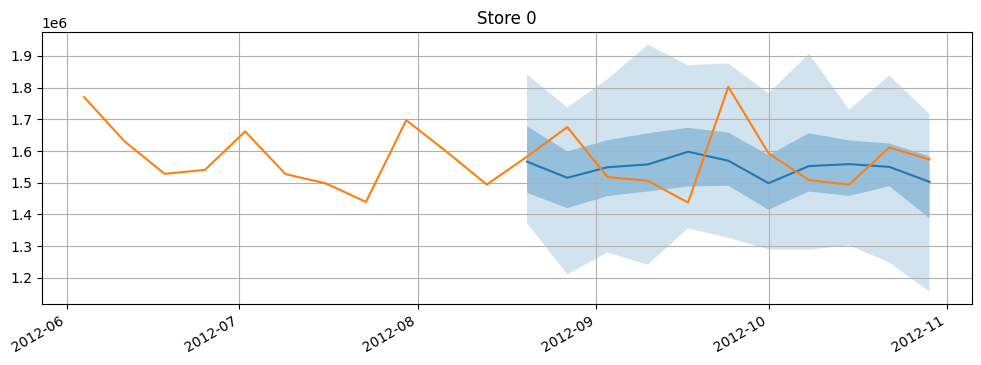

/usr/local/lib/python3.11/dist-packages/pandas/plotting/_matplotlib/core.py:975: UserWarning: This axis already has a converter set and is updating to a potentially incompatible converter
  return ax.plot(*args, **kwds)


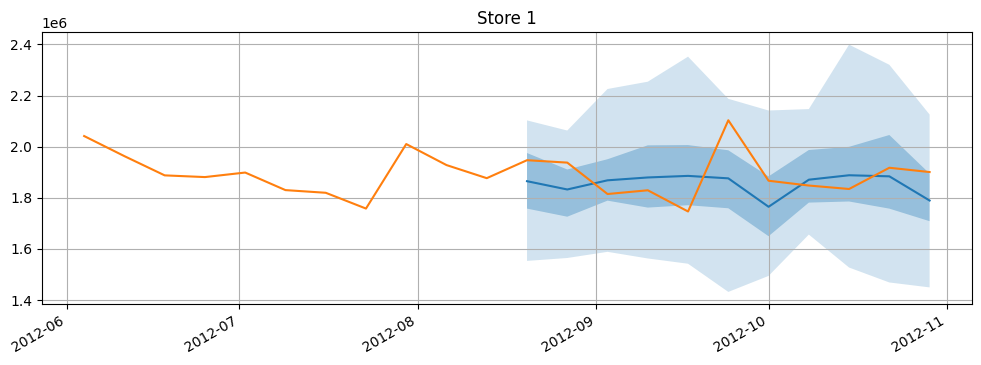

/usr/local/lib/python3.11/dist-packages/pandas/plotting/_matplotlib/core.py:975: UserWarning: This axis already has a converter set and is updating to a potentially incompatible converter
  return ax.plot(*args, **kwds)


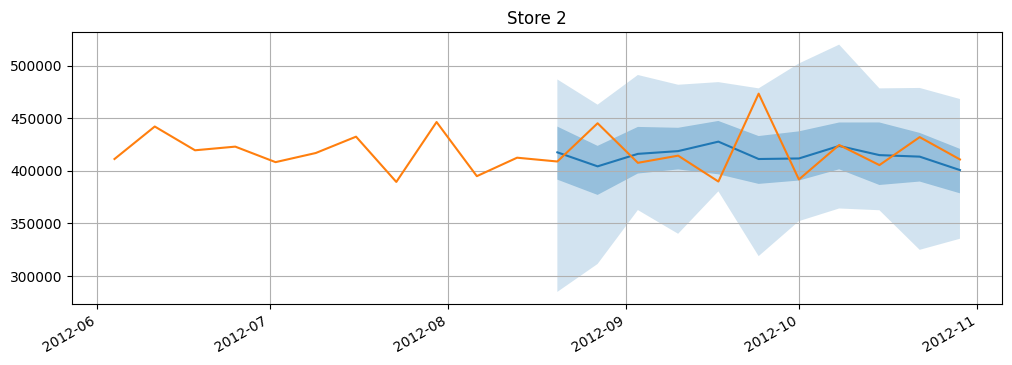

/usr/local/lib/python3.11/dist-packages/pandas/plotting/_matplotlib/core.py:975: UserWarning: This axis already has a converter set and is updating to a potentially incompatible converter
  return ax.plot(*args, **kwds)


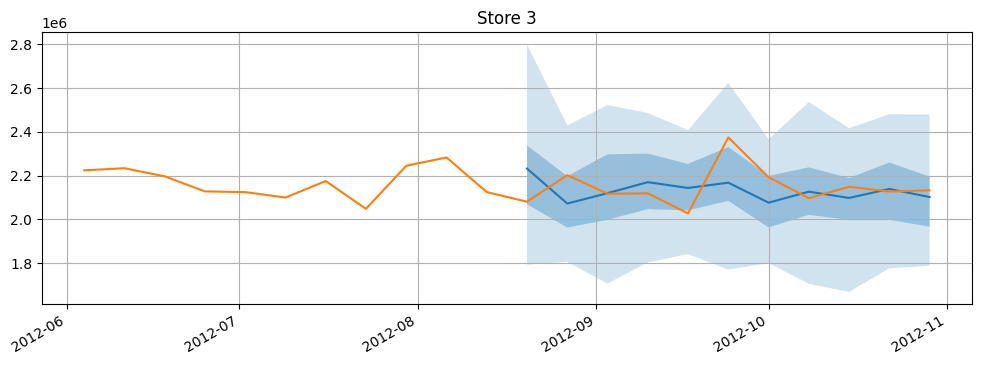

/usr/local/lib/python3.11/dist-packages/pandas/plotting/_matplotlib/core.py:975: UserWarning: This axis already has a converter set and is updating to a potentially incompatible converter
  return ax.plot(*args, **kwds)


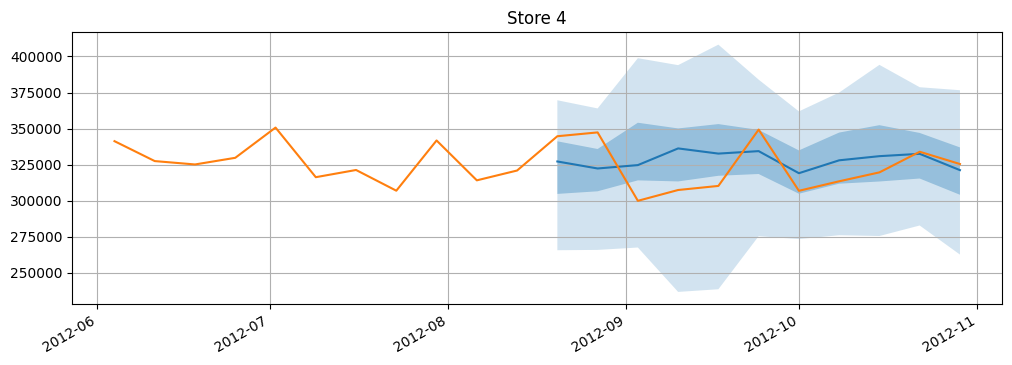

In [12]:
for k in range(5): #len(forecasts)):
  fig, ax1 = plt.subplots(1, 1, figsize=(12, 4))
  forecasts[k].plot(ax = ax1)
  tss[k].plot(ax = ax1)
  ax1.get_legend().remove()
  plt.grid(which="both")
  plt.title("Store " + str(k) )
  plt.show()

In [13]:
from gluonts.evaluation import Evaluator

evaluator = Evaluator()
agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(test_data_lds))

import json
print(json.dumps(agg_metrics, indent=4))

Running evaluation: 100%|██████████| 45/45 [00:00<00:00, 1403.26it/s]


{
    "MSE": 8352883591.498989,
    "abs_error": 30995031.53125,
    "abs_target_sum": 508089357.75,
    "abs_target_mean": 1026443.1469696971,
    "seasonal_error": 58367.47604166667,
    "MASE": 1.182774066570701,
    "MAPE": 0.06316787811240764,
    "sMAPE": 0.06177818865487068,
    "MSIS": 10.974238100981049,
    "num_masked_target_values": 0.0,
    "QuantileLoss[0.1]": 13206409.081250003,
    "Coverage[0.1]": 0.07272727272727272,
    "QuantileLoss[0.2]": 20477949.625,
    "Coverage[0.2]": 0.24242424242424246,
    "QuantileLoss[0.3]": 26001116.44375,
    "Coverage[0.3]": 0.3656565656565656,
    "QuantileLoss[0.4]": 29270136.400000002,
    "Coverage[0.4]": 0.4707070707070707,
    "QuantileLoss[0.5]": 30995031.46875,
    "Coverage[0.5]": 0.604040404040404,
    "QuantileLoss[0.6]": 30890163.737499997,
    "Coverage[0.6]": 0.717171717171717,
    "QuantileLoss[0.7]": 28819006.3625,
    "Coverage[0.7]": 0.7878787878787877,
    "QuantileLoss[0.8]": 24623512.1,
    "Coverage[0.8]": 0.88080

## Monte Carlo simulation

In [14]:
!pip install yfinance

In [17]:
import yfinance as yf
orig = yf.download(["AAPL"], start="2020-01-01", end="2024-12-31")
orig = orig[('Close')]
orig.tail()

[*********************100%***********************]  1 of 1 completed


Ticker,AAPL
Date,
2024-12-23,254.655716
2024-12-24,257.578674
2024-12-26,258.396667
2024-12-27,254.974930
2024-12-30,251.593079


array([[<Axes: title={'center': 'AAPL'}>]], dtype=object)

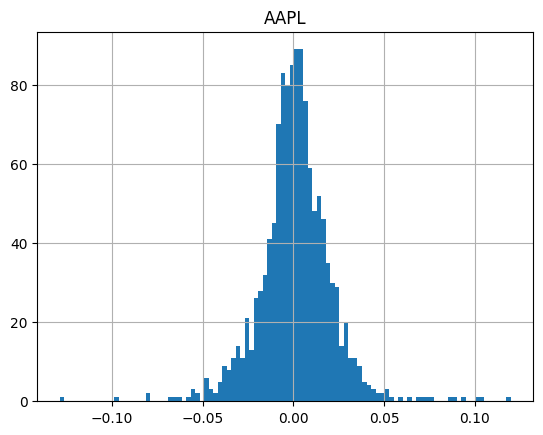

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
returns = orig.pct_change()
last_price = orig['AAPL'].tail(1).values[0]
returns.hist(bins=100)

In [29]:
daily_volatility = returns.std()
daily_volatility

,0
Ticker,
AAPL,0.019962


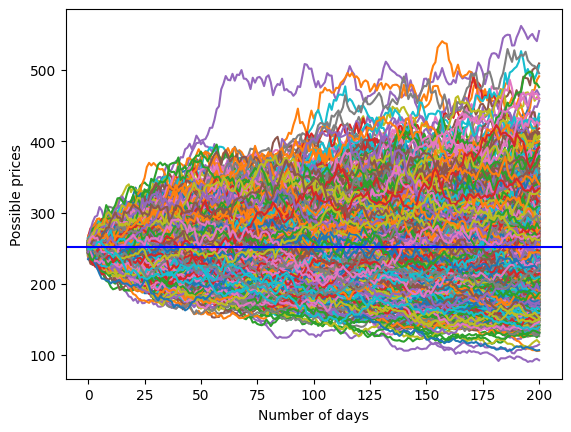

In [30]:
import warnings
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

num_simulations = 1000
num_days = 200
simulation_df = pd.DataFrame()

for x in range(num_simulations):
    count = 0

    # The first price point
    price_series = []
    rtn = np.random.normal(0, daily_volatility)
    price = last_price * (1  + rtn)
    price_series.append(price)

    # Create each price path
    for g in range(num_days):
        rtn = np.random.normal(0, daily_volatility)
        price = price_series[g] * (1  + rtn)
        price_series.append(price)

    # Save all the possible price paths
    simulation_df[x] = price_series

fig = plt.figure()
plt.plot(simulation_df)
plt.xlabel('Number of days')
plt.ylabel('Possible prices')
plt.axhline(y = last_price, color = 'b', linestyle = '-')
plt.show()

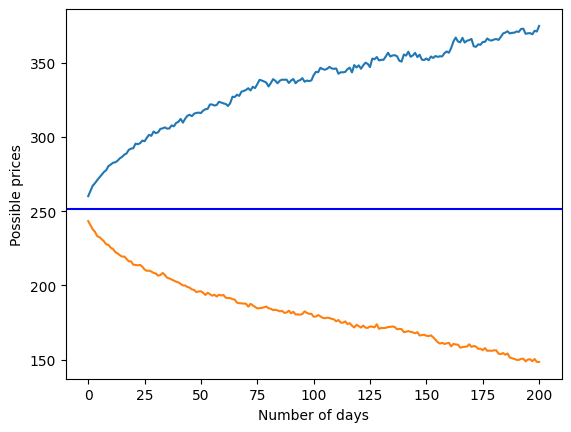

In [31]:
upper = simulation_df.quantile(.95, axis=1)
lower = simulation_df.quantile(.05, axis=1)
stock_range = pd.concat([upper, lower], axis=1)

fig = plt.figure()
plt.plot(stock_range)
plt.xlabel('Number of days')
plt.ylabel('Possible prices')

plt.axhline(y = last_price, color = 'b', linestyle = '-')
plt.show()